реализации всяких штук и сравнения с sklearn

In [65]:
import numpy as np
from sklearn.utils import check_X_y, resample, check_array

from sklearn.base import BaseEstimator, ClassifierMixin, clone, RegressorMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_is_fitted

class CustomBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, n_estimators=100, seed=42):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.seed = seed
        self.models = []

    def fit(self, X, y):
        X, y = check_X_y(X,y)
        self.classes = unique_labels(y)
        rng = np.random.RandomState(self.seed)
        for _ in range(self.n_estimators):
            X_sample, y_sample = resample(X, y, random_state=rng.randint(0, int(1e6)))
            model = clone(self.base_model)
            model.fit(X_sample, y_sample)

            self.models.append(model)

        return self

    def predict_proba(self, X):
        check_is_fitted(self, 'models')
        X = check_array(X)
        probabilities = np.array([model.predict_proba(X) for model in self.models])

        return np.mean(probabilities, axis=0)

    def predict(self, X):
        avg_probabilities = self.predict_proba(X)

        return self.classes[np.argmax(avg_probabilities, axis=1)]

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeClassifier

def evaluate_classification(y_true, y_pred, model_name):
    """
    Вывод метрик для задачи классификации.

    :param y_true: Истинные метки.
    :param y_pred: Предсказанные метки.
    :param model_name: Название модели.
    """
    print(f"{model_name}")
    print(f"acc: {accuracy_score(y_true, y_pred):.4f}")
    print(f"precision: {precision_score(y_true, y_pred):.4f}")
    print(f"recall: {recall_score(y_true, y_pred):.4f}")
    print(f"f1: {f1_score(y_true, y_pred):.4f}")
    try:
        print(f"roc auc: {roc_auc_score(y_true, y_pred):.4f}")
    except ValueError:
        print("roc auc: не может быть вычислен (присутствует только один класс)")
    print()

In [67]:
from sklearn.datasets import make_regression, make_classification
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_clf, y_clf = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42)

base_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)

custom_bagging_clf = CustomBaggingClassifier(base_model=base_classifier, n_estimators=50, seed=42)
custom_bagging_clf.fit(X_train_clf, y_train_clf)
custom_predictions_clf = custom_bagging_clf.predict(X_test_clf)
evaluate_classification(y_test_clf, custom_predictions_clf, 'Custom Bagging Classifier')

sklearn_bagging_clf = BaggingClassifier(estimator=base_classifier, n_estimators=50, random_state=42)
sklearn_bagging_clf.fit(X_train_clf, y_train_clf)
sklearn_predictions_clf = sklearn_bagging_clf.predict(X_test_clf)
evaluate_classification(y_test_clf, sklearn_predictions_clf, 'sklearn Bagging Classifier')

Custom Bagging Classifier
acc: 0.8633
precision: 0.8851
recall: 0.8452
f1: 0.8647
roc auc: 0.8640

sklearn Bagging Classifier
acc: 0.8533
precision: 0.8828
recall: 0.8258
f1: 0.8533
roc auc: 0.8543



порядок чиселок в целом не важен, важно что получилось похоже на sklearn

дальше градиентный бустинг и всё то же самое


In [68]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import check_X_y, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.base import clone
from scipy.special import expit
import numpy as np

class CustomGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, n_estimators=100, learning_rate=1.0):
        self.base_model = base_model
        self.num_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []

    def _sigmoid(self, x):
        return expit(x)

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes = unique_labels(y)
        if len(self.classes) > 2:
            raise ValueError("only binary classification is supported")
        y_binary = np.copy(y)
        if set(self.classes) != {0, 1}:
            y_binary = np.where(y == self.classes[1], 1, 0)

        self.models = []
        y_pred_proba = np.zeros_like(y_binary, dtype=float)

        for _ in range(self.num_estimators):
            proba = self._sigmoid(y_pred_proba)
            residuals = y_binary - proba

            pseudo_classes = np.where(residuals >= 0, 1, 0)
            model = clone(self.base_model)
            model.fit(X, pseudo_classes)

            pred = model.predict(X)
            update = 2 * pred - 1
            y_pred_proba += self.learning_rate * update
            self.models.append(model)

        return self

    def predict_proba(self, X):
        check_is_fitted(self, 'models')
        X = check_array(X)

        raw_scores = np.zeros(X.shape[0], dtype=float)
        for model in self.models:
            pred = model.predict(X)
            update = 2 * pred - 1
            raw_scores += self.learning_rate * update

        probas = self._sigmoid(raw_scores)

        return np.vstack([1 - probas, probas]).T

    def predict(self, X):
            probas = self.predict_proba(X)
            return self.classes[np.argmax(probas, axis=1)]

In [69]:
#yeah
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


X_clf, y_clf = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.3, random_state=42)

base_classifier = DecisionTreeClassifier(max_depth=1, random_state=42)
custom_gradient = CustomGradientBoostingClassifier(base_model=base_classifier, n_estimators=50)
custom_gradient.fit(X_train_clf, y_train_clf)
custom_predictions_clf = custom_gradient.predict(X_test_clf)
evaluate_classification(y_test_clf, custom_predictions_clf, 'Custom Gradient Boosting Classifier')

sklearn_gradient_clf = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
sklearn_gradient_clf.fit(X_train_clf, y_train_clf)
sklearn_predictions_clf = sklearn_gradient_clf.predict(X_test_clf)
evaluate_classification(y_test_clf, sklearn_predictions_clf, 'sklearn Gradient Boosting Classifier')

lgbm_clf = LGBMClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, verbosity=-1, random_state=42)
lgbm_clf.fit(X_train_clf, y_train_clf)
lgbm_predictions_clf = lgbm_clf.predict(X_test_clf)
evaluate_classification(y_test_clf, lgbm_predictions_clf, 'LightGBM Classifier')

xgb_clf = XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_clf, y_train_clf)
xgb_predictions_clf = xgb_clf.predict(X_test_clf)
evaluate_classification(y_test_clf, xgb_predictions_clf, 'XGBoost Classifier')

catboost_clf = CatBoostClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42, verbose=False)
catboost_clf.fit(X_train_clf, y_train_clf)
catboost_predictions_clf = catboost_clf.predict(X_test_clf)
evaluate_classification(y_test_clf, catboost_predictions_clf, 'CatBoost Classifier')

Custom Gradient Boosting Classifier
acc: 0.8400
precision: 0.8365
recall: 0.8581
f1: 0.8471
roc auc: 0.8394

sklearn Gradient Boosting Classifier
acc: 0.8667
precision: 0.8859
recall: 0.8516
f1: 0.8684
roc auc: 0.8672

LightGBM Classifier
acc: 0.8667
precision: 0.8966
recall: 0.8387
f1: 0.8667
roc auc: 0.8676

XGBoost Classifier
acc: 0.8667
precision: 0.8912
recall: 0.8452
f1: 0.8675
roc auc: 0.8674

CatBoost Classifier
acc: 0.8633
precision: 0.8750
recall: 0.8581
f1: 0.8664
roc auc: 0.8635



ok hand emoji

теперь метрики литрики граммчики

In [70]:
import numpy as np
from sklearn.metrics import confusion_matrix

def custom_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def custom_precision(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fp = cm[0, 1]
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def custom_recall(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    fn = cm[1, 0]
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def custom_f1_score(y_true, y_pred):
    prec = custom_precision(y_true, y_pred)
    rec = custom_recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

def custom_auc_roc(y_true, y_prob):
    sorted_indices = np.argsort(y_prob)[::-1]
    y_true_sorted = np.array(y_true)[sorted_indices]

    tpr = [0]
    fpr = [0]
    tp = 0
    fp = 0
    total_pos = np.sum(y_true)
    total_neg = len(y_true) - total_pos

    for label in y_true_sorted:
        if label == 1:
            tp += 1
        else:
            fp += 1
        tpr.append(tp / total_pos)
        fpr.append(fp / total_neg)

    auc = 0
    for i in range(1, len(tpr)):
        auc += (fpr[i] - fpr[i - 1]) * (tpr[i] + tpr[i - 1]) / 2
    return auc

def custom_auc_pr(y_true, y_prob):
    sorted_indices = np.argsort(y_prob)[::-1]
    y_true_sorted = np.array(y_true)[sorted_indices]

    precision_values = []
    recall_values = []
    tp = 0
    fp = 0
    total_pos = np.sum(y_true)

    for label in y_true_sorted:
        if label == 1:
            tp += 1
        else:
            fp += 1
        precision_values.append(tp / (tp + fp))
        recall_values.append(tp / total_pos)

    auc = 0
    for i in range(1, len(recall_values)):
        auc += (recall_values[i] - recall_values[i - 1]) * (precision_values[i] + precision_values[i - 1]) / 2
    return auc

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

y_true = np.random.randint(0, 2, size=1000)
y_pred = np.random.randint(0, 2, size=1000)
y_prob = np.random.rand(1000)

print("Accuracy:")
print("Custom:", custom_accuracy(y_true, y_pred))
print("Sklearn:", accuracy_score(y_true, y_pred))

print("\nPrecision:")
print("Custom:", custom_precision(y_true, y_pred))
print("Sklearn:", precision_score(y_true, y_pred))

print("\nRecall:")
print("Custom:", custom_recall(y_true, y_pred))
print("Sklearn:", recall_score(y_true, y_pred))

print("\nF1-Score:")
print("Custom:", custom_f1_score(y_true, y_pred))
print("Sklearn:", f1_score(y_true, y_pred))

print("\nAUC-ROC:")
print("Custom:", custom_auc_roc(y_true, y_prob))
print("Sklearn:", roc_auc_score(y_true, y_prob))

print("\nAUC-PR:")
print("Custom:", custom_auc_pr(y_true, y_prob))
print("Sklearn:", average_precision_score(y_true, y_prob))

Accuracy:
Custom: 0.494
Sklearn: 0.494

Precision:
Custom: 0.492
Sklearn: 0.492

Recall:
Custom: 0.4939759036144578
Sklearn: 0.4939759036144578

F1-Score:
Custom: 0.49298597194388777
Sklearn: 0.49298597194388777

AUC-ROC:
Custom: 0.44347109553752867
Sklearn: 0.4434710955375286

AUC-PR:
Custom: 0.45189076691260666
Sklearn: 0.4536992166188086


math is kinda mathin'

EDA

берёшь пельмени


In [72]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

солишь

In [73]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL                  15000 non-null 

In [74]:
train.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,42.606000,164.672667,64.282000,80.323180,1.032727,1.025927,1.005533,1.004933,119.149467,...,57.535667,113.158533,14.510340,1.016533,0.866580,22.272667,20.874933,26.290200,0.139467,0.366600
std,4330.271354,10.415341,8.558684,10.973871,7.932701,0.312845,0.313488,0.074183,0.070067,11.167046,...,11.380739,18.442012,1.392921,0.157464,0.168492,6.324422,10.314009,20.431882,0.346444,0.481892
min,0.000000,20.000000,140.000000,35.000000,0.900000,0.100000,0.100000,1.000000,1.000000,82.000000,...,28.000000,41.000000,7.200000,1.000000,0.100000,9.000000,4.000000,6.000000,0.000000,0.000000
25%,3749.750000,40.000000,160.000000,55.000000,75.000000,0.800000,0.800000,1.000000,1.000000,110.000000,...,49.000000,100.000000,13.500000,1.000000,0.800000,18.000000,14.000000,15.000000,0.000000,0.000000
50%,7499.500000,40.000000,165.000000,65.000000,80.000000,1.000000,1.000000,1.000000,1.000000,119.000000,...,56.000000,112.000000,14.700000,1.000000,0.900000,21.000000,18.000000,21.000000,0.000000,0.000000
75%,11249.250000,50.000000,170.000000,70.000000,86.000000,1.200000,1.200000,1.000000,1.000000,128.000000,...,65.000000,126.000000,15.600000,1.000000,1.000000,25.000000,24.000000,31.000000,0.000000,1.000000
max,14999.000000,80.000000,190.000000,120.000000,121.000000,9.900000,9.900000,2.000000,2.000000,190.000000,...,105.000000,193.000000,28.900000,5.000000,1.600000,324.000000,190.000000,566.000000,1.000000,1.000000


сразу отрежем колонку 'id'. Потом посмотрим на категориальные признаки

In [75]:
train = train.drop(columns=['id'], errors='ignore')

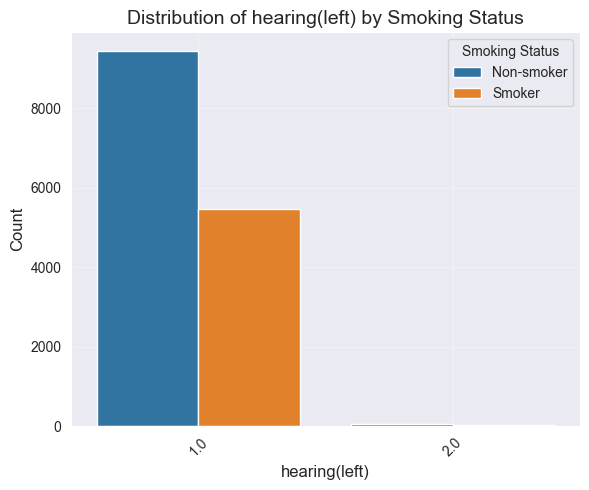

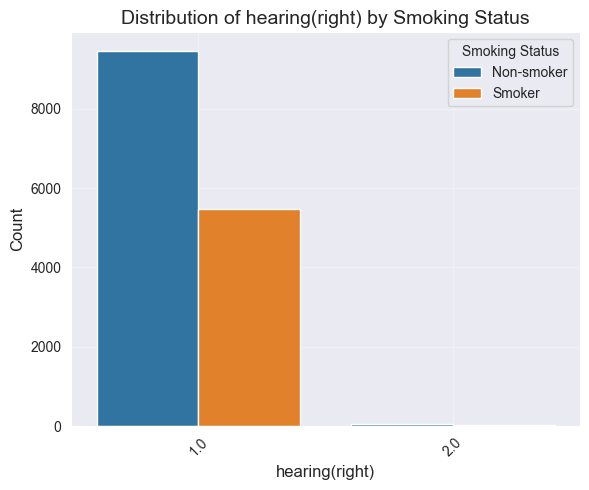

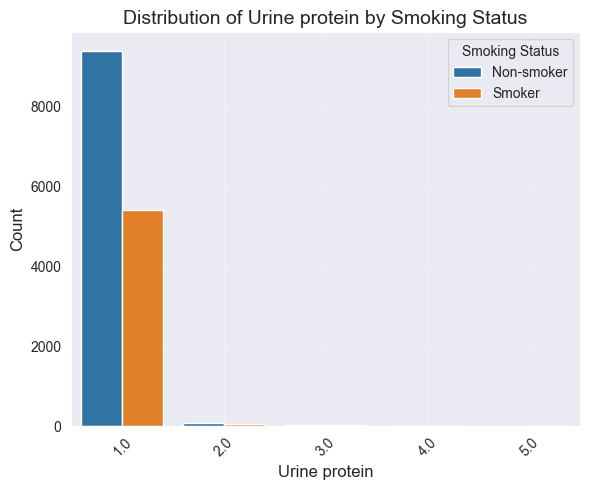

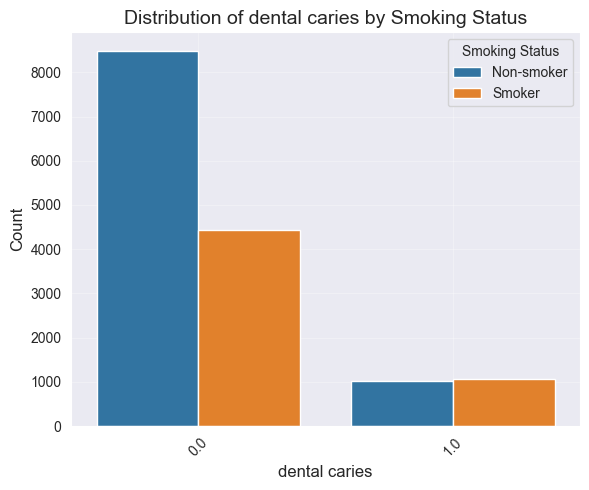

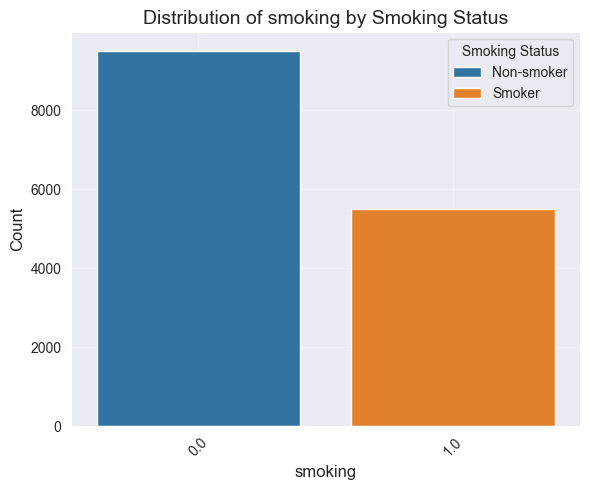

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_features = [col for col in train.columns if (train[col].nunique() < 6)]
numeric_features = [col for col in train.columns if (col not in categorical_features and col != 'smoking')]

for feature in categorical_features:
    plt.figure(figsize=(6, 5))
    sns.countplot(x=feature, hue='smoking', data=train)

    plt.title(f'Distribution of {feature} by Smoking Status', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(['Non-smoker', 'Smoker'], title='Smoking Status')
    plt.grid(True, alpha=0.3)

    # Отображение графика
    plt.tight_layout()
    plt.show()


In [77]:
smokers_ratio = train['smoking'].value_counts()[1] / len(train['smoking']) * 100
print(smokers_ratio)

36.66


курильщики : некурильщики = 1 : 2. дисбаланс.

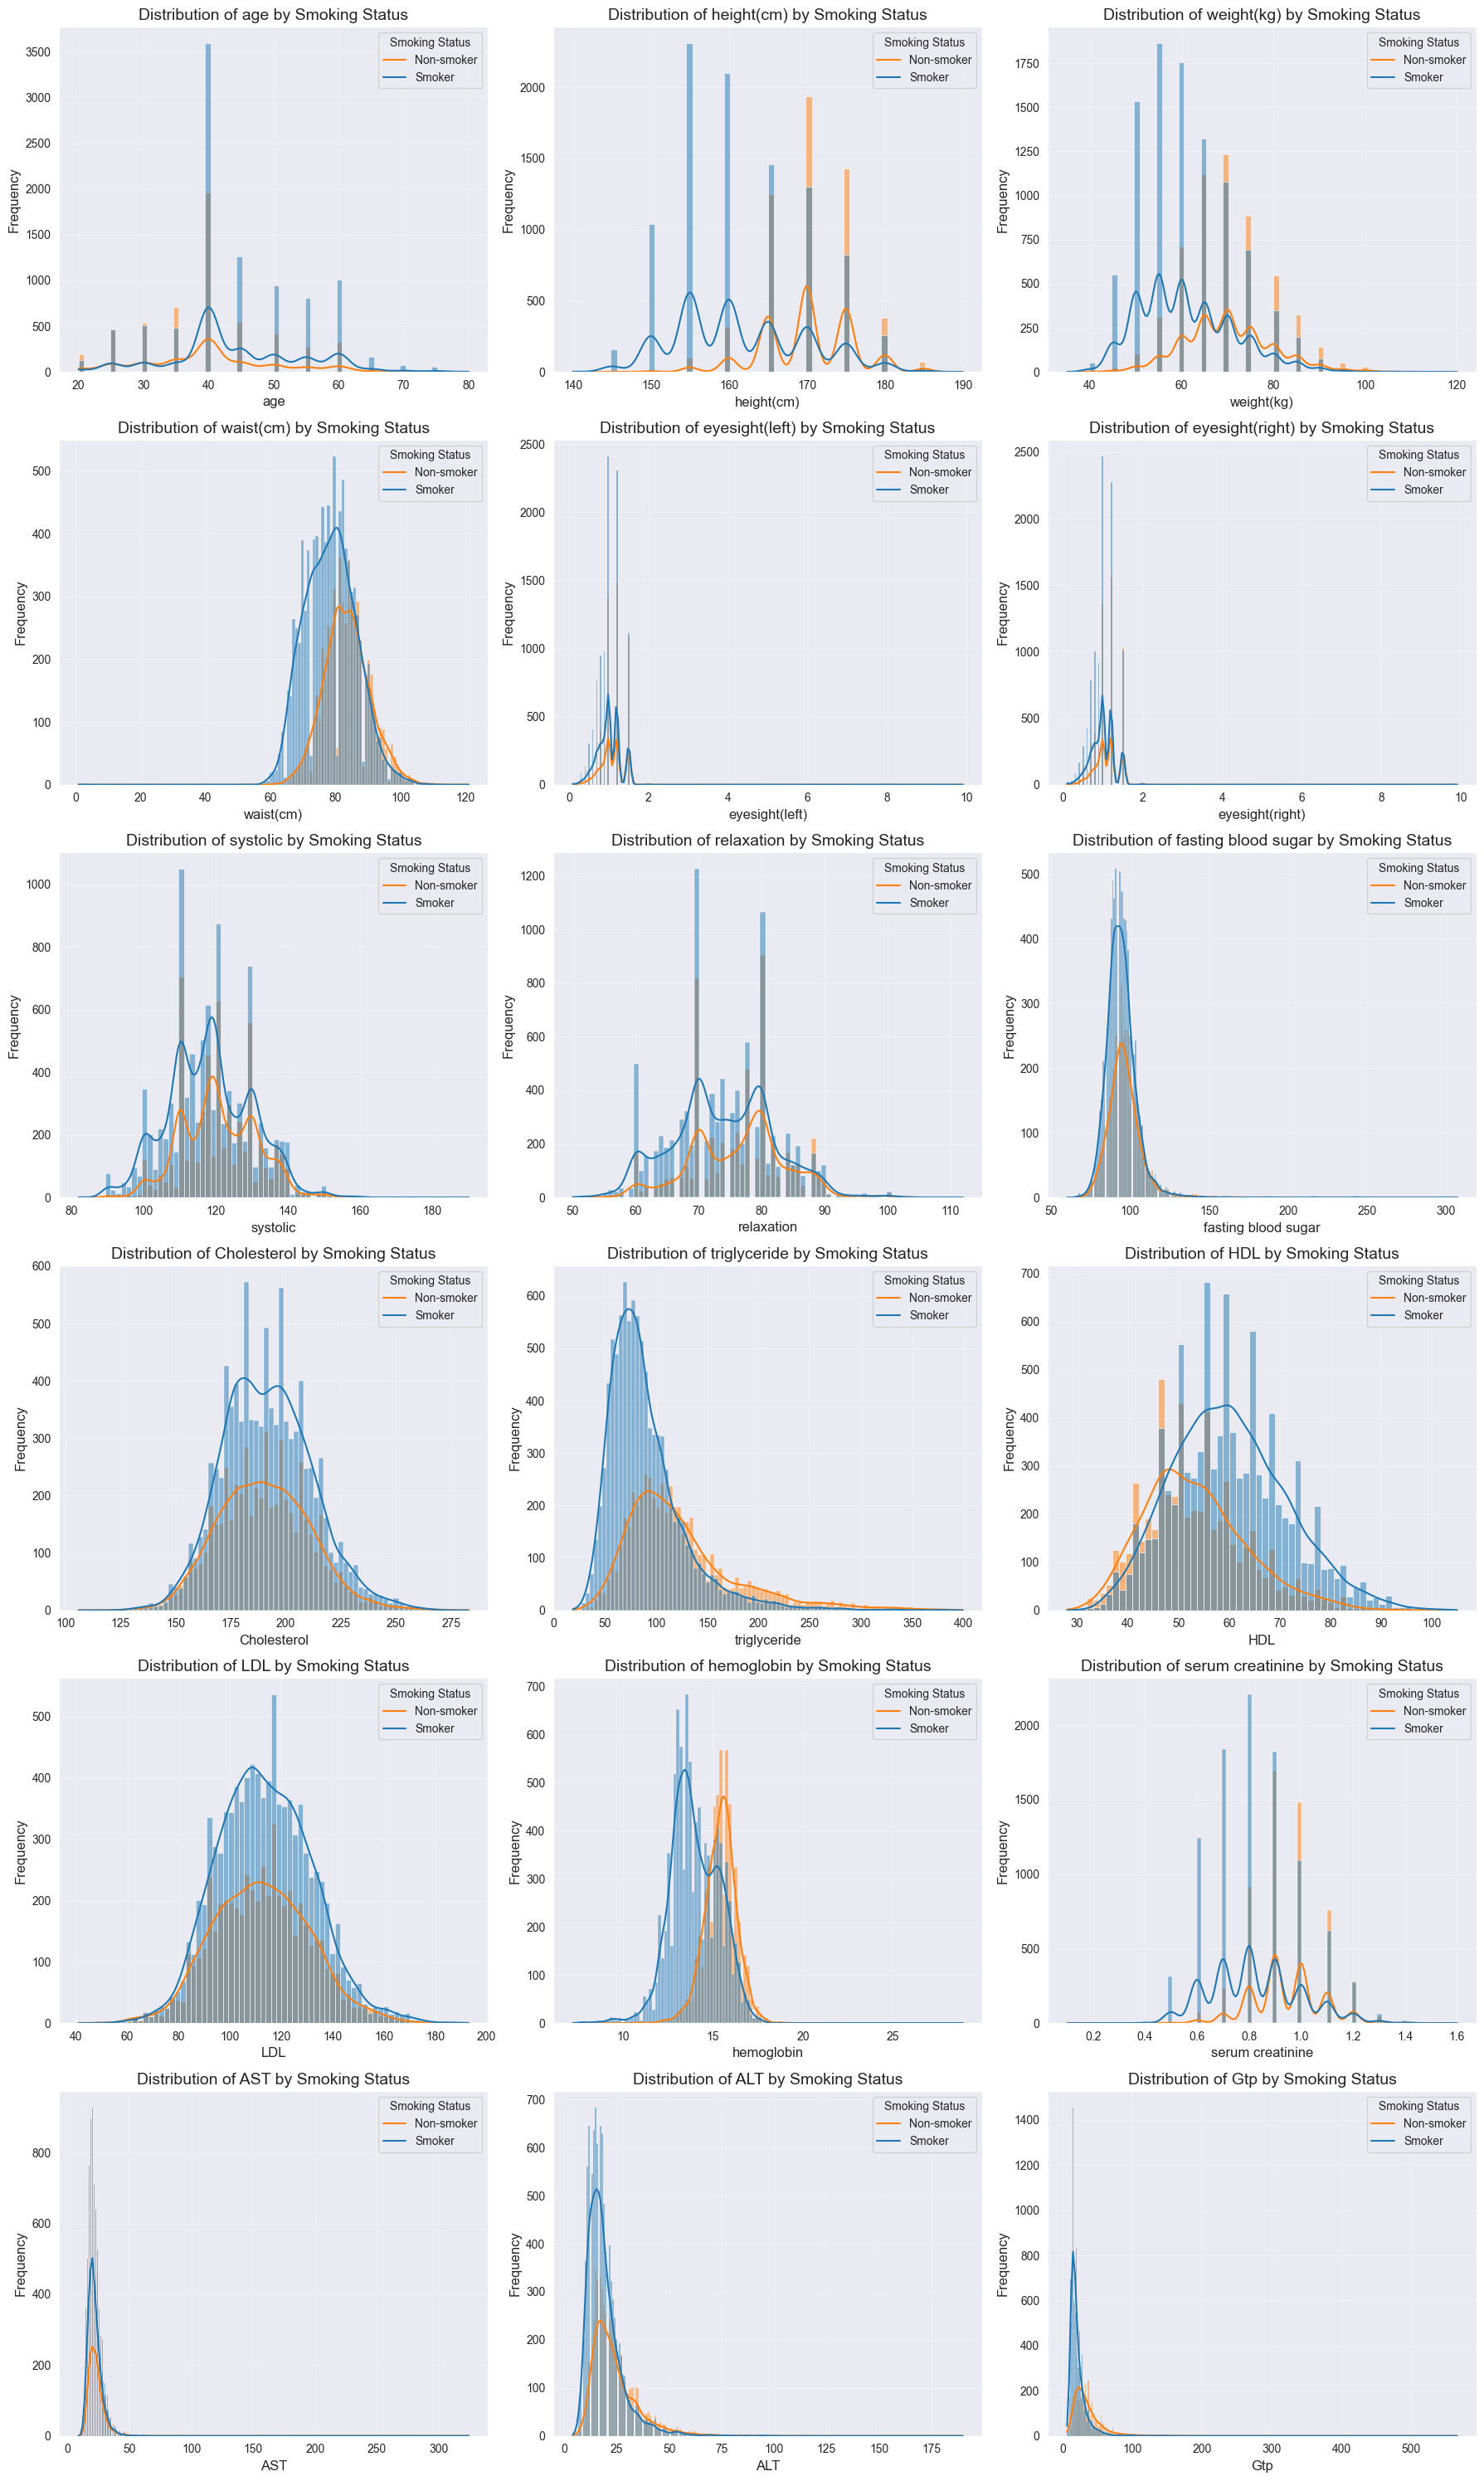

In [78]:
import numpy as np

n_numeric = len(numeric_features)
rows = int(np.ceil(n_numeric / 3))
plt.figure(figsize=(18, rows * 5))

for i, feature in enumerate(numeric_features, 1):
    plt.subplot(rows, 3, i)
    sns.histplot(data=train, x=feature, hue='smoking', kde=True)
    plt.title(f'Distribution of {feature} by Smoking Status', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(['Non-smoker', 'Smoker'], title='Smoking Status')

plt.tight_layout()
plt.show()

заберём признаки, в которых есть скосы. потом их прологарифмируем.

In [79]:
train_without_target = train.drop(columns=['smoking'])

num_cols = train_without_target.select_dtypes(include=['number']).columns.tolist()
skewed = train_without_target[num_cols].skew().sort_values(ascending=False)
skewed_cols = skewed[skewed > 0.8].index.tolist()

skewed_cols

['hearing(right)',
 'hearing(left)',
 'Urine protein',
 'AST',
 'Gtp',
 'eyesight(left)',
 'eyesight(right)',
 'fasting blood sugar',
 'ALT',
 'dental caries',
 'triglyceride']

In [80]:
for col in skewed_cols:
    train[f'log1p_{col}'] = np.log1p(np.maximum(train[col], 0))
    test[f'log1p_{col}'] = np.log1p(np.maximum(test[col], 0))

ещё и выбросы порежем

In [81]:
for col in numeric_features:
    q1, q99 = train[col].quantile(0.01), train[col].quantile(0.99)
    train[col] = train[col].clip(q1, q99)

заберём только важные признаки через случайный лес

In [82]:
def select_most_valuable_features(features, target, importance_ratio=0.7, correlation_limit=0.9, seed=42, display_count=20):
    forest_model = RandomForestClassifier(n_estimators=100, random_state=seed)
    forest_model.fit(features, target)
    importances = forest_model.feature_importances_
    importance_table = pd.DataFrame({
        'feature': features.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)

    best_features_count = int(len(importance_table) * importance_ratio)
    best_features = importance_table.iloc[:best_features_count]['feature'].tolist()

    selected_data = features[best_features].copy()
    correlation_matrix = selected_data.corr().abs()
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )
    highly_correlated = [col for col in upper_triangle.columns if any(upper_triangle[col] > correlation_limit)]
    features_ = [feat for feat in best_features if feat not in highly_correlated]


    filtered_features = selected_data[features_]
    print(f"Топ-{display_count} важных признаков:")
    top_displayed = importance_table[importance_table['feature'].isin(features_)].head(display_count)
    for _, row in top_displayed.iterrows():
        print(f"Признак: {row['feature']}, Важность: {row['importance']}")

    # Итоговая информация
    print(f"\nfeatures total: {filtered_features.shape[1]}")
    return features_

In [83]:
X_train = train.drop(columns=['smoking'], errors='ignore')
y_train = train['smoking']

selected = select_most_valuable_features(X_train, y_train, importance_ratio=0.9)
X_train = X_train[selected]
X_test = test[selected]

Топ-20 важных признаков:
Признак: hemoglobin, Важность: 0.11734988615610241
Признак: height(cm), Важность: 0.09702986531785278
Признак: log1p_Gtp, Важность: 0.07321227172438075
Признак: log1p_triglyceride, Важность: 0.05269357254443881
Признак: serum creatinine, Важность: 0.04457011448018494
Признак: weight(kg), Важность: 0.041419271645310986
Признак: waist(cm), Важность: 0.03632575156353591
Признак: HDL, Важность: 0.03477307874046196
Признак: LDL, Важность: 0.03464295771289199
Признак: Cholesterol, Важность: 0.034637300080726185
Признак: age, Важность: 0.031058957933678535
Признак: systolic, Важность: 0.028664460614017066
Признак: log1p_fasting blood sugar, Важность: 0.02789228782187351
Признак: relaxation, Важность: 0.02783466869519072
Признак: log1p_ALT, Важность: 0.027695858441435316
Признак: log1p_AST, Важность: 0.025024370815910225
Признак: log1p_eyesight(right), Важность: 0.014762666781603335
Признак: log1p_eyesight(left), Важность: 0.014315831047138792
Признак: log1p_dental car

In [84]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

base_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)
custom_bagging_clf = CustomBaggingClassifier(base_model=base_classifier, n_estimators=100, seed=42)
custom_gb_clf = CustomGradientBoostingClassifier(base_model=base_classifier, n_estimators=100, learning_rate=0.1)

acc_scores = {'custom bagging': [], 'custom gb': []}
prec_scores = {'custom bagging': [], 'custom gb': []}
f1_scores = {'custom bagging': [], 'custom gb': []}
recall_scores = {'custom bagging': [], 'custom gb': []}
roc_auc_scores = {'custom bagging': [], 'custom gb': []}
auc_pr_scores = {'custom bagging': [], 'custom gb': []}

X_train, y_train = train.drop(columns=['smoking'], errors='ignore'), train['smoking']

for train_id, test_id in cv.split(X_train, y_train):
    X_cv_train, X_cv_test = X_train.iloc[train_id], X_train.iloc[test_id]
    y_cv_train, y_cv_test = y_train.iloc[train_id], y_train.iloc[test_id]

    custom_bagging_clf.fit(X_cv_train, y_cv_train)
    custom_gb_clf.fit(X_cv_train, y_cv_train)

    y_bagging_pred = custom_bagging_clf.predict(X_cv_test)
    y_gb_pred = custom_gb_clf.predict(X_cv_test)

    acc_scores['custom bagging'].append(custom_accuracy(y_cv_test, y_bagging_pred))
    prec_scores['custom bagging'].append(custom_precision(y_cv_test, y_bagging_pred))
    f1_scores['custom bagging'].append(custom_f1_score(y_cv_test, y_bagging_pred))
    recall_scores['custom bagging'].append(custom_recall(y_cv_test, y_bagging_pred))
    roc_auc_scores['custom bagging'].append(custom_auc_roc(y_cv_test, y_bagging_pred))
    auc_pr_scores['custom bagging'].append(custom_auc_pr(y_cv_test, y_bagging_pred))

    acc_scores['custom gb'].append(custom_accuracy(y_cv_test, y_gb_pred))
    prec_scores['custom gb'].append(custom_precision(y_cv_test, y_gb_pred))
    f1_scores['custom gb'].append(custom_f1_score(y_cv_test, y_gb_pred))
    recall_scores['custom gb'].append(custom_recall(y_cv_test, y_gb_pred))
    roc_auc_scores['custom gb'].append(custom_auc_roc(y_cv_test, y_gb_pred))
    auc_pr_scores['custom gb'].append(custom_auc_pr(y_cv_test, y_gb_pred))

metric_names = ['acc', 'prec', 'f1', 'recall', 'roc_auc', 'auc_pr']
metrics_dict = [acc_scores, prec_scores, f1_scores, recall_scores, roc_auc_scores, auc_pr_scores]

for metric_name, metric_scores in zip(metric_names, metrics_dict):
    for model_name, scores in metric_scores.items():
        print(f"{model_name} {metric_name}: {np.mean(scores)}")

custom bagging acc: 0.7700000000000001
custom gb acc: 0.7570666666666667
custom bagging prec: 0.7026973455566916
custom gb prec: 0.7019431958481754
custom bagging f1: 0.6724128423961135
custom gb f1: 0.6392651041416906
custom bagging recall: 0.6461053850607991
custom gb recall: 0.5871957978327405
custom bagging roc_auc: 0.7415892200383641
custom gb roc_auc: 0.7198236436031509
custom bagging auc_pr: 0.6194789862861916
custom gb auc_pr: 0.6024937371907565


сравним с другими реализациями

In [95]:
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

model_definitions = {
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "LightGBM_Balanced": LGBMClassifier(random_state=42, class_weight='balanced'),
    "XGBoost_Weighted": XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
    ),
    "CatBoost_AutoBalanced": CatBoostClassifier(verbose=False, random_state=42, auto_class_weights='Balanced')
}

evaluation_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'f1_score': 'f1',
    'recall': 'recall',
    'roc_auc': 'roc_auc',
}

performance_results = {}

for model_name, model_instance in model_definitions.items():
    processing_pipeline = ImbPipeline([
        ('balancing', SMOTE(random_state=42)),
        ('classifier', model_instance)
    ])

    validation_scores = cross_validate(
        processing_pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring=evaluation_metrics,
        n_jobs=-1,
        return_train_score=False
    )

    performance_results[model_name] = {
        metric: (np.mean(validation_scores[f'test_{metric}']), np.std(validation_scores[f'test_{metric}']))
        for metric in evaluation_metrics.keys()
    }

    print(model_name)
    for metric_name, (mean_value, std_value) in performance_results[model_name].items():
        print(f"  {metric_name}: {mean_value}")

best_model = max(performance_results, key=lambda model: performance_results[model]['roc_auc'][0])
print(f"\nbest model on roc-auc: {best_model}")

GradientBoosting
  accuracy: 0.7956
  precision: 0.6831958075082418
  f1_score: 0.747516751192738
  recall: 0.8254198031268094
  roc_auc: 0.8837498656817928
LightGBM_Balanced
  accuracy: 0.8016
  precision: 0.7068162752319822
  f1_score: 0.7435469649239851
  recall: 0.7845045909504509
  roc_auc: 0.8862391675895858
XGBoost_Weighted
  accuracy: 0.7969333333333334
  precision: 0.6853159673797136
  f1_score: 0.7486917110913909
  recall: 0.8250571594011085
  roc_auc: 0.8779061103574526
CatBoost_AutoBalanced
  accuracy: 0.8041333333333334
  precision: 0.7102808877735532
  f1_score: 0.7465468179364565
  recall: 0.7868670692364961
  roc_auc: 0.8876304722234025

best model on roc-auc: CatBoost_AutoBalanced


In [86]:
best_model_name = 'CatBoost'

теперь optuna для гиперпараметров

In [87]:
from sklearn.utils import compute_class_weight
from sklearn.model_selection import cross_val_score
import optuna

def create_model(trial, model_name):
    if model_name == "LightGBM":
        return LGBMClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 2000),
            max_depth=trial.suggest_int("max_depth", 3, 16),
            learning_rate=trial.suggest_float("learning_rate", 0.005, 0.3),
            num_leaves=trial.suggest_int("num_leaves", 20, 500),
            min_child_samples=trial.suggest_int("min_child_samples", 5, 200),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            reg_alpha=trial.suggest_float("reg_alpha", 0.0, 5.0),
            reg_lambda=trial.suggest_float("reg_lambda", 0.0, 5.0),
            min_split_gain=trial.suggest_float("min_split_gain", 0.0, 1.0),
            class_weight='balanced',
            random_state=42
        )

    elif model_name == "XGBoost":
        scale_pos_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)[1]
        return XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 1000),
            max_depth=trial.suggest_int("max_depth", 3, 12),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            gamma=trial.suggest_float("gamma", 0, 5),
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )

    elif model_name == "CatBoost":
        return CatBoostClassifier(
            iterations=trial.suggest_int("iterations", 100, 1200),
            depth=trial.suggest_int("depth", 3, 9),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.15),
            l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1, 10),
            auto_class_weights='Balanced',
            verbose=0,
            random_state=42
        )

    else:
        return GradientBoostingClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 1000),
            max_depth=trial.suggest_int("max_depth", 3, 12),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.5, 1.0),
            random_state=42
        )

def objective(trial):
    model = create_model(trial, best_model_name)

    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best trial:")
print(study.best_trial)

[I 2025-05-20 13:26:35,816] A new study created in memory with name: no-name-63868ab7-8ba5-490f-a871-d355cfd3b065
[I 2025-05-20 13:27:30,605] Trial 0 finished with value: 0.8847296476037997 and parameters: {'iterations': 539, 'depth': 7, 'learning_rate': 0.06689878378637044, 'l2_leaf_reg': 6.637484679240572}. Best is trial 0 with value: 0.8847296476037997.
[I 2025-05-20 13:28:15,542] Trial 1 finished with value: 0.8811241641561256 and parameters: {'iterations': 623, 'depth': 7, 'learning_rate': 0.1476447270097219, 'l2_leaf_reg': 8.990139401212538}. Best is trial 0 with value: 0.8847296476037997.
[I 2025-05-20 13:28:35,983] Trial 2 finished with value: 0.8847783104076076 and parameters: {'iterations': 310, 'depth': 7, 'learning_rate': 0.08633938189338514, 'l2_leaf_reg': 4.373844044264809}. Best is trial 2 with value: 0.8847783104076076.
[I 2025-05-20 13:29:19,716] Trial 3 finished with value: 0.8870313400714498 and parameters: {'iterations': 1139, 'depth': 3, 'learning_rate': 0.05294380

Best trial:
FrozenTrial(number=14, state=TrialState.COMPLETE, values=[0.8883136584979635], datetime_start=datetime.datetime(2025, 5, 20, 13, 36, 11, 28229), datetime_complete=datetime.datetime(2025, 5, 20, 13, 36, 44, 318772), params={'iterations': 1007, 'depth': 4, 'learning_rate': 0.033840127433433925, 'l2_leaf_reg': 7.5624795319632}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1200, log=False, low=100, step=1), 'depth': IntDistribution(high=9, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.15, log=False, low=0.01, step=None), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None)}, trial_id=14, value=None)


In [88]:
best_params = study.best_params
if best_model_name == 'LightGBM':
    best_model = LGBMClassifier(**best_params, random_state=42)
elif best_model_name == 'XGBoost':
    best_model = XGBClassifier(**best_params, random_state=42, useLabelEncoder=False, eval_metric='logloss')
elif best_model_name == 'CatBoost':
    best_model = CatBoostClassifier(**best_params, verbose=False, random_state=42)
else:
    best_model = GradientBoostingClassifier(**best_params, random_state=42)

pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', best_model)
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000001C16AE359C0>)])

In [89]:
X_test = test
y_test_pred = pipeline.predict_proba(X_test)[:,1]

kaggle_sub = pd.DataFrame({"id" : test["id"], "smoking": y_test_pred})
kaggle_sub.to_csv("submission.csv", index=False)